# Laboratory 6

**Author:** Dario Barone

 #### Loading packages

In [9]:
library("tidyverse")
library("gridExtra")
library("magrittr")
library(showtext)
showtext_auto()

## Exercise 1

#### Uniform prior analysis

The experiment is repeated $5$ times, giving $5$ different measures. In order to compute the posterior distribution over these data, the prior gets updated after each measure is taken into account.

The likelihood is represented by a Poisson distribution over the number of occurrences $y$. As a function of the occurrence rate $\mu\in\left[0,\infty\right)$, the likelihood becomes the Gamma distribution parametrized by $y$, so there will be a different likelihood for each of the measures. The likelihood will be

$$P\!\left(y_i\,|\,\mu\right) = \frac{\mu^{y_i}\:e^{-\mu}}{y_i!}$$

The sampling interval for the variable $\mu$ must be determined. Since, for the Poisson distribution, both the mean and the standard deviation are $\mu$, then with good probability all the measures taken will lay within the interval $y_i\in\left[0,4\mu_{\max}\right]$, where $\mu_\text{max}$ is an estimation of the maximum occurrence rate. Considering $\mu_\text{max} = \max_i y_i$, all the tails of the probabilities involved in the exercise should be sufficiently negligible.

The prior chosen is the uniform prior $P\!\left(\mu\right)=U\!\left(0,\mu_\text{max}\right)$.

Since the prior is uniform, its presence introduces only a multiplicative constant to a non-normalized likelihood distribution, so the posterior will result to be the product of the likelihoods obtained from each measure. Since the denominator in the likelihood is the normalization factor of the Poisson distribution, which is useless in this case, so the posterior can be computed as

$$P\!\left(\mu\,|\,y\right) = \frac{1}{Z}\prod_i \mu^{y_i}\:e^{-\mu} = \frac{1}{Z}\:\mu^{\sum_i y_i}\:e^{-n\mu}$$

where $n$ is the number of measures and the normalization factor $Z$ is computed afterwards imposing $\int_0^{\mu_\text{max}} P\!\left(\mu\,|\,y\right)\:d\mu = 1$.

The posterior has the form of a Gamma distribution with parameters $\alpha = 1 + \sum_i y_i$ and $\beta = n$, thus the mean, median and variance should assume the values:

$$\text{mean} = \frac{\alpha}{\beta} \qquad \text{med} = ? \qquad \text{var} = \frac{\alpha}{\beta^2}$$

In [4]:
# measurement interval
dt = 10
# measures
n.emitted = c(4, 1, 3, 1, 3)
# sampling interval
mu_max = 4 * max(n.emitted)
mus = seq(0, mu_max, length=101)


In [5]:
# utility functions to build the posterior
product = function(f, g) {
    force(f)
    force(g)
    return( function(p) {return(f(p) * g(p))} )
}
replace.with = function(f) {
    force(f)
    return( function(p) {return(f(p))} )
}

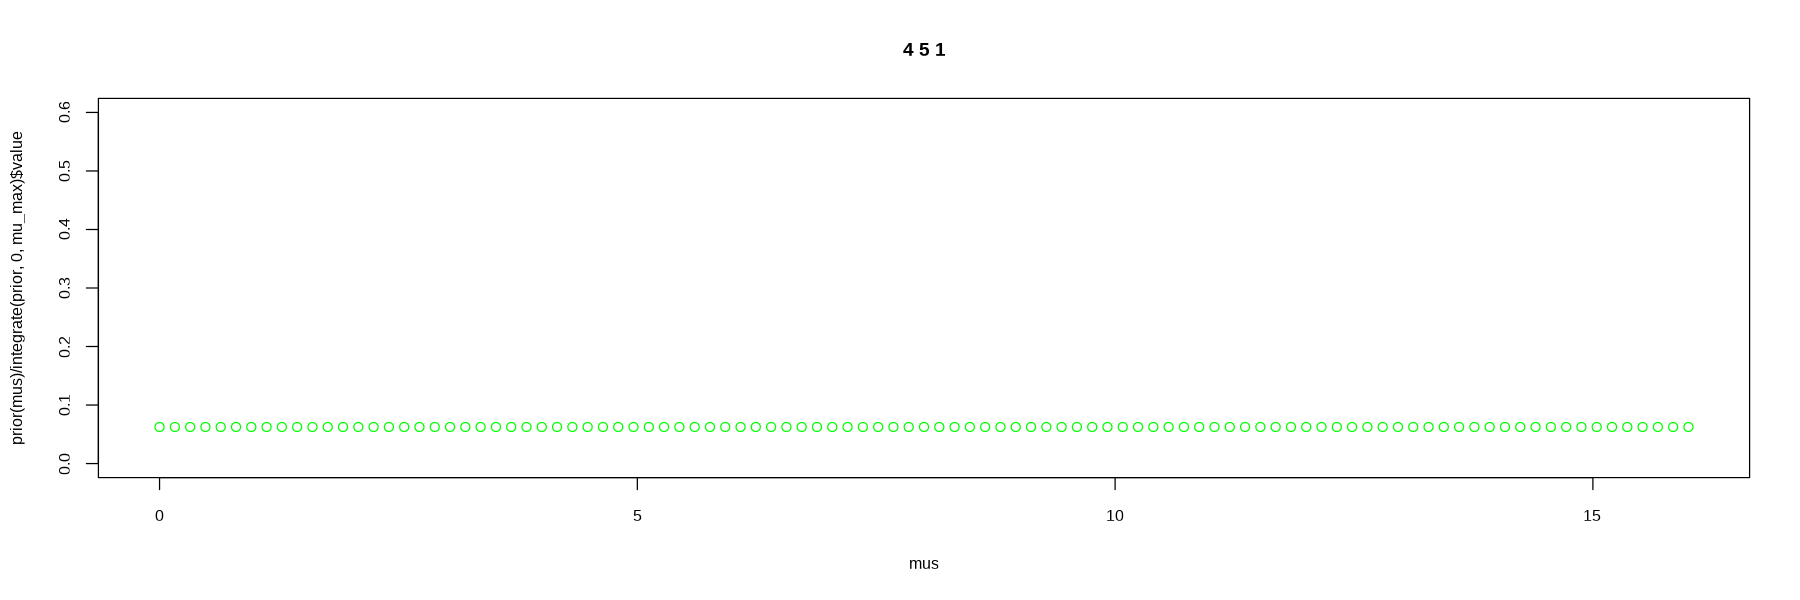

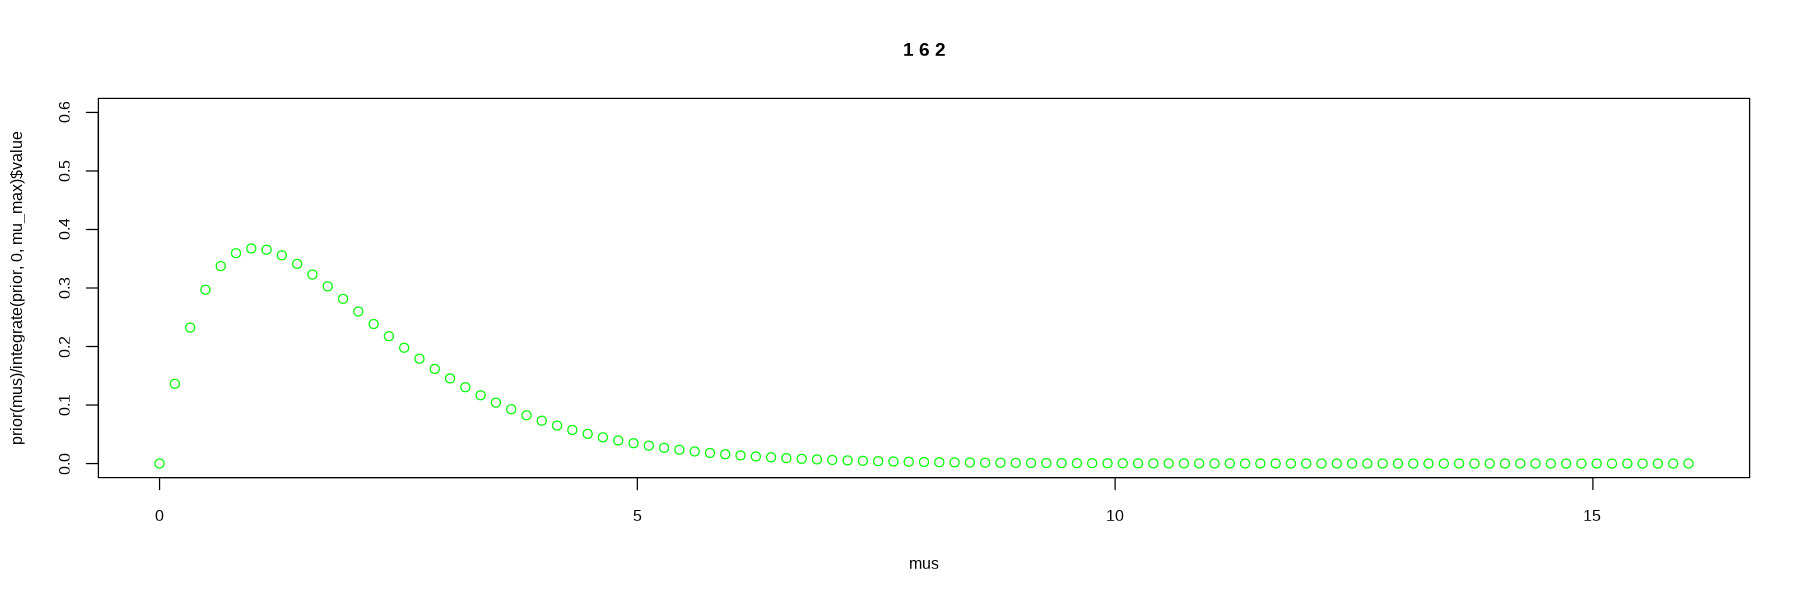

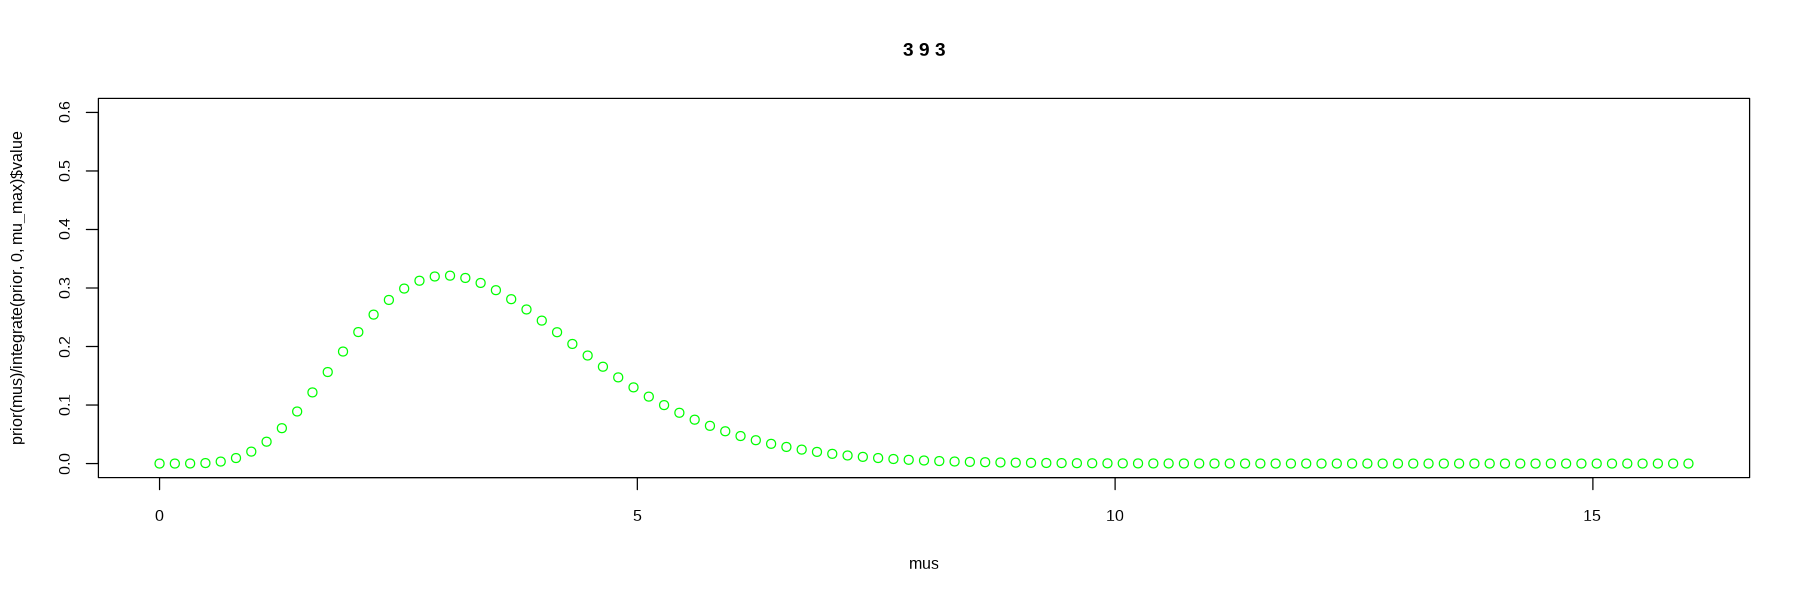

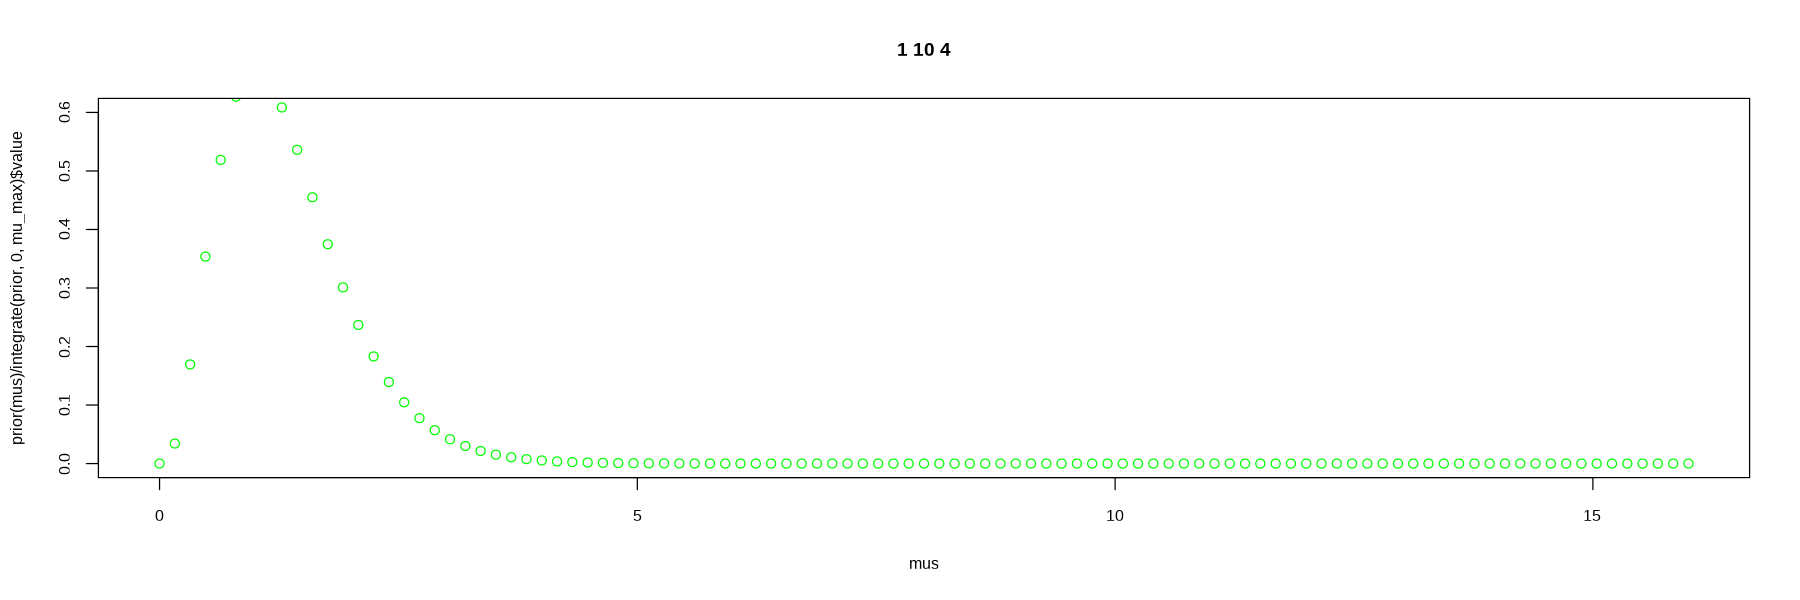

Warning message:
“The `value` argument of `names<-` must have the same length as `x` as of tibble 3.0.0.
`names` must have length 1, not 11.”

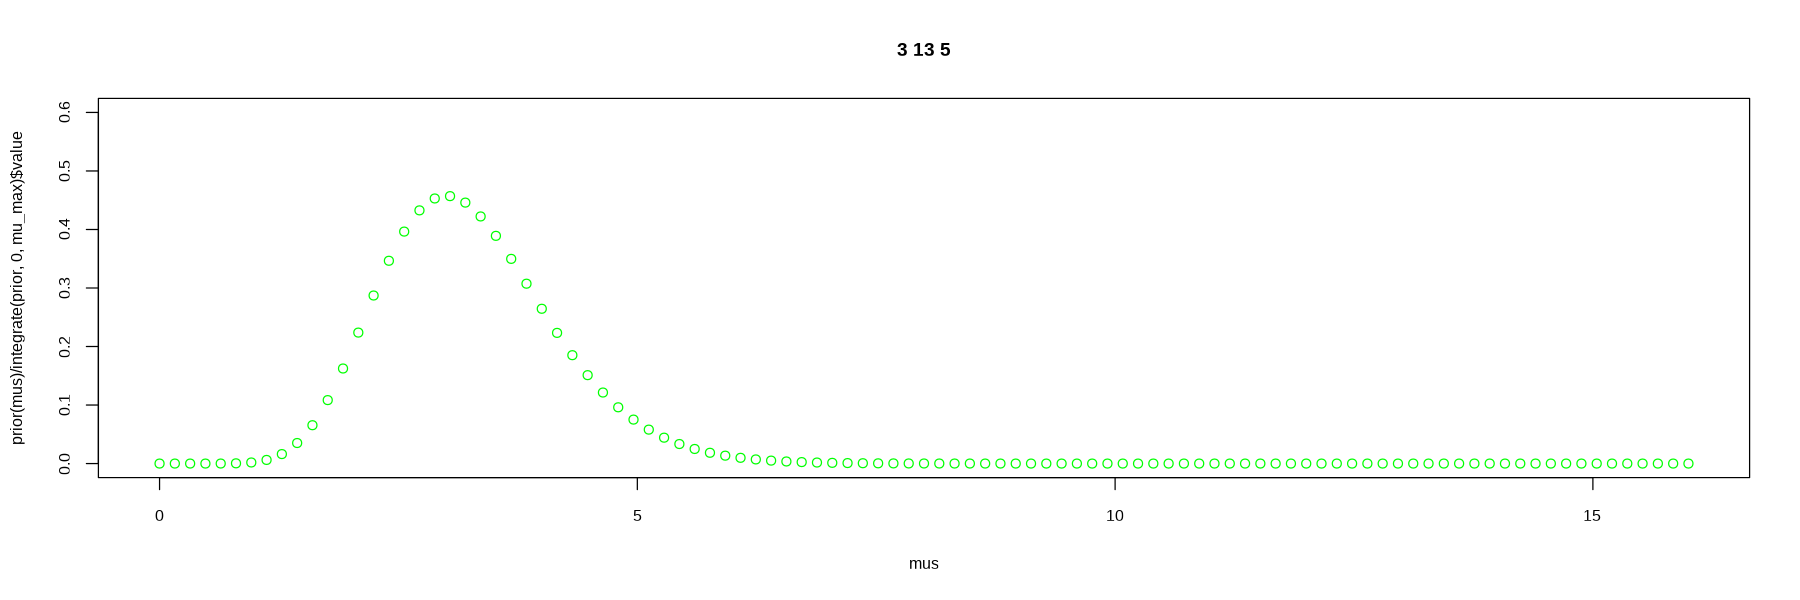

In [14]:
# computing the posterior
prior = function(p) { return(dunif(p, 0, mu_max)) }
#############
tempa = 1
tempb = 0
options(repr.plot.width=15, repr.plot.height=5)
df.prova = tibble(a=1:101)
idx = 1
#############
for (y in n.emitted){
    #############
    tempa = tempa + y
    tempb = tempb + 1
    prova = function(x){return(dgamma(x, tempa, tempb))}
    #############
    df.prova %<>% add_column(a=prior(mus)/integrate(prior,0,mu_max)$value, .name_repair="minimal")  ######################
    plot(mus, prior(mus)/integrate(prior,0,mu_max)$value, main=paste(y, tempa, tempb), ylim=c(0,0.6), col="green") ######################
    likelihood = function(p) { return(dpois(y, p)) }
    lines(mus, likelihood(mus), col="blue")                                     ######################
    lines(mus,prova(mus)/integrate(prova,0,mu_max)$value)                       ######################
    posterior = product(prior, likelihood)
    lines(mus, posterior(mus)/integrate(posterior,0,mu_max)$value, col="red")   ######################
    prior = posterior#replace.with(posterior)
    df.prova %<>% add_column(a=prior(mus)/integrate(prior,0,mu_max)$value, .name_repair="minimal")  ######################
    points(mus, prior(mus)/integrate(prior,0,mu_max)$value, col="purple")       ######################
    idx = idx + 1                                                               ######################
    cat("\n\n")                                                                 ######################
}
############
names(df.prova) = c("x","beg1","end1","beg2","end2","beg3","end3","beg4","end4","beg5","end5")
############
Z = integrate(posterior, 0, mu_max)$value

In [15]:
# plotting
options(repr.plot.width=15, repr.plot.height=5)
dataframe = tibble(mu = posterior(mus) / Z)
plt = ggplot(dataframe, aes(x=mus)) +
        ggtitle("Posterior given uniform prior") + ylab(expression(P(mu~"|"~y))) + xlab(expression(mu)) + labs(col="") +
        geom_line(aes(y=mu)) + geom_point(aes(y=mu)) +
        theme(text=element_text(size=20), , plot.title=element_text(hjust=0.5))

In [16]:
# evaluating theoretical relevant quantities
alpha = 1 + sum(n.emitted)
beta = length(n.emitted)
theo.mean = alpha / beta
theo.var = alpha / beta^2
# evaluating empirical relevant quantities
compute.mean = function(x) { return(x * posterior(x) / Z) }
emp.mean = integrate(compute.mean, 0, mu_max)$value
emp.med = uniroot(function(x){integrate(posterior,0,x)$value/Z - 0.5}, c(0,mu_max))$root
compute.var = function(x) { return(posterior(x) / Z * (x - emp.mean)^2) }
emp.var = integrate(compute.var, 0, mu_max)$value
# printing
cat("Theoretical mean = ",theo.mean,"\tEmpirical mean = ",emp.mean)
cat("\n")
cat("Empirical median\t= ",emp.med)
cat("\n")
cat("Theoretical variance\t= ",theo.var,"\tEmpirical variance\t= ",emp.var)

plt = plt + geom_vline(aes(xintercept=theo.mean, color="Theoretical mean"), lty="dotted", size=1) +
            geom_vline(aes(xintercept=emp.mean, color="Empirical mean"), lty="dotted", size=1) +
            geom_vline(aes(xintercept=emp.med, color="Empirical median"), lty="dotted", size=1)
prova = function(x){ return(dgamma(x,alpha,beta)) }                     ###################
plt + geom_line(aes(y=prova(mus)/integrate(prova, 0, mu_max)$value, color="Cosa dovrebbe uscire"))    ##########

Theoretical mean =  2.6 	Empirical mean =  3.2
Empirical median	=  3.133586
Theoretical variance	=  0.52 	Empirical variance	=  0.64

ERROR while rich displaying an object: Error in FUN(X[[i]], ...): object 'beg1' not found

Traceback:
1. FUN(X[[i]], ...)
2. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
3. tryCatchList(expr, classes, parentenv, handlers)
4. tryCatchOne(expr, names, parentenv, handlers[[1L]])
5. doTryCatch(return(expr), name, parentenv, handler)
6. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler)
7. repr::mime2repr[[mime]](obj)
8. repr_text.default(obj)
9. paste(cap

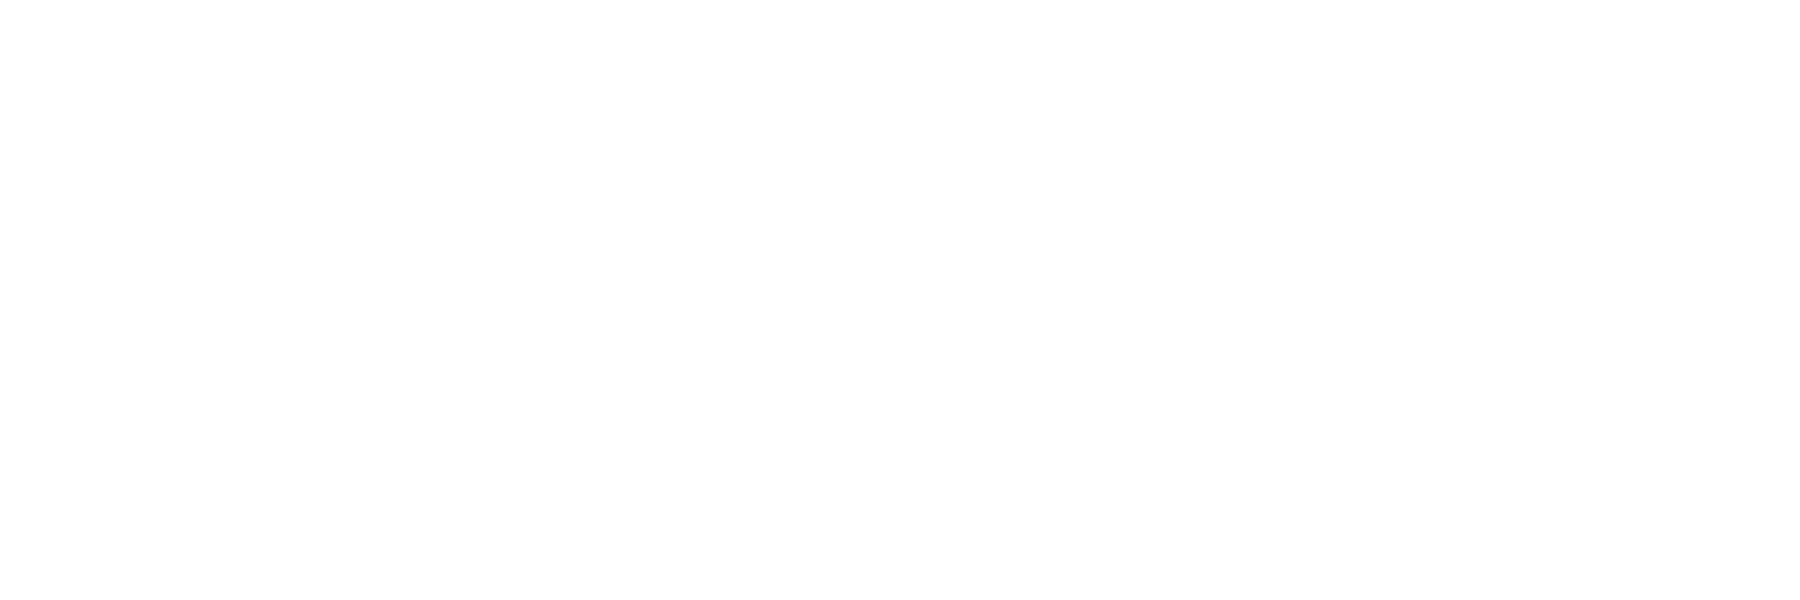

In [17]:
ggplot(df.prova, aes(x=x)) + ggtitle("DEBUG: priors at the beginning and end of the for loop, for each iteration") +
    geom_line(aes(y=beg1, color="1 - Beginning")) +
    geom_point(aes(y=end1, color="1 - End")) +
    geom_line(aes(y=beg2, color="2 - Beginning")) +
    geom_point(aes(y=end2, color="2 - End")) +
    geom_line(aes(y=beg3, color="3 - Beginning")) +
    geom_point(aes(y=end3, color="3 - End")) +
    geom_line(aes(y=beg4, color="4 - Beginning")) +
    geom_point(aes(y=end4, color="4 - End")) +
    geom_line(aes(y=beg5, color="5 - Beginning")) +
    geom_point(aes(y=end5, color="5 - End")) +
    guides(color=guide_legend(override.aes=list(lty=rep(c(1,0),5), shape=rep(c(NA,16),5))))